# **Build an Image Classification Model for Animals**

We are using a dataset from [kaggle](https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals) to be able to classify 36 different classes of animal. Out of 90 animals provided in the dataset, we filtered down to 36 animals that are more likely to be the most familiar animals for kids

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
dir_path = '/content/drive/MyDrive/Capstone Project/animals'
#create a new folder
new_path = '/content/drive/MyDrive/Capstone Project/filtered_animals'

In [3]:
training_path = os.path.join(new_path, 'training')
testing_path = os.path.join(new_path, 'testing')

In [ ]:
os.makedirs(training_path)
os.makedirs(testing_path)

In [ ]:
for file in os.listdir(dir_path):
  file_path = os.path.join(dir_path, file)

  train = os.path.join(training_path, file)
  test = os.path.join(testing_path, file)
  os.makedirs(train)
  os.makedirs(test)

  #training
  for img in os.listdir(file_path)[:48]:
    img_path = os.path.join(file_path, img)
    new_img_path = os.path.join(train, img)
    shutil.copyfile(img_path, new_img_path)

  #testing
  for img in os.listdir(file_path)[48:]:
    img_path = os.path.join(file_path, img)
    new_img_path = os.path.join(test, img)
    shutil.copyfile(img_path, new_img_path)

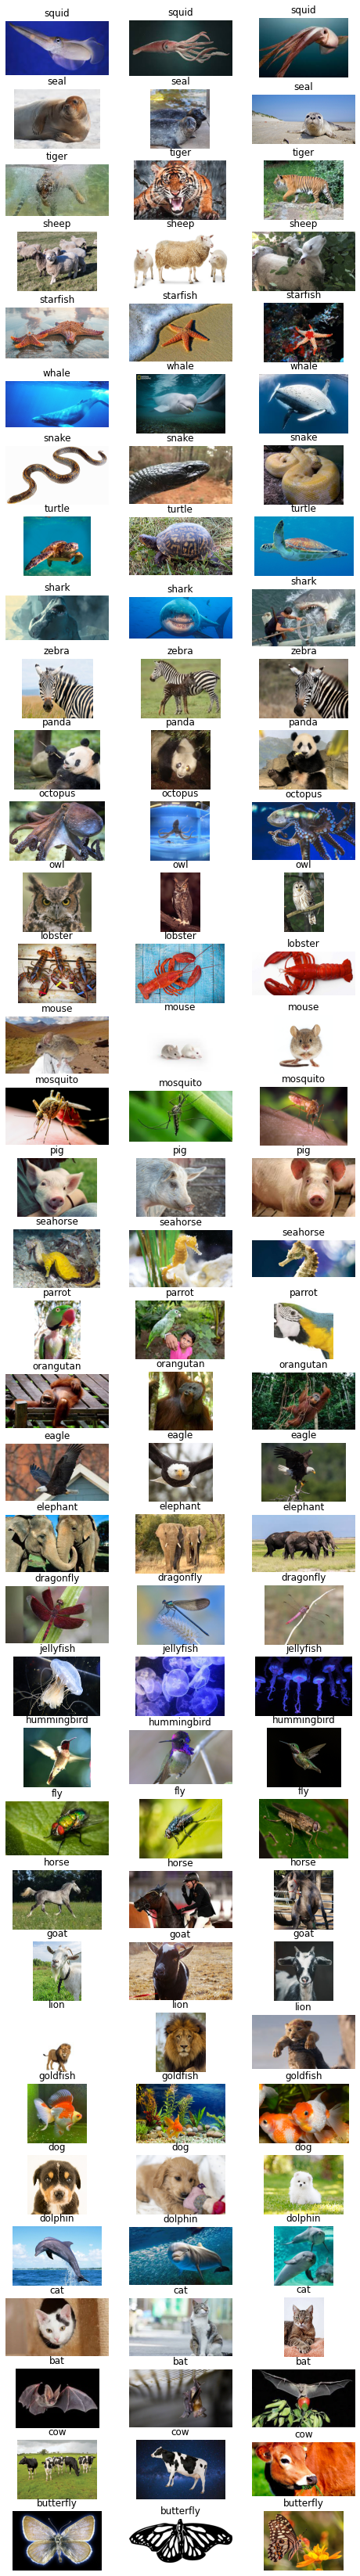

In [ ]:
fig = plt.figure(figsize=(8,60))

i=0
for file in os.listdir(training_path):
  for img in os.listdir(training_path+'/'+file)[:3]:
    ax = fig.add_subplot(len(os.listdir(training_path)), 3, i + 1)
    i+=1
    
    ax.axis('Off') # Don't show axes (or gridlines)
    plt.imshow(mpimg.imread(training_path+'/'+file+'/'+img))
    plt.title(file)

In [4]:
training_datagen = ImageDataGenerator(rescale=1/255.0,
                                      zoom_range=0.25,
                                      shear_range=0.2,
                                      rotation_range=30,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      horizontal_flip=True)

testing_datagen = ImageDataGenerator(rescale=1/255.0)

training_generator = training_datagen.flow_from_directory(training_path,
                                                          batch_size=16,
                                                          target_size=(150,150),
                                                          class_mode='categorical')

testing_generator = testing_datagen.flow_from_directory(testing_path,
                                                          batch_size=16,
                                                          target_size=(150,150),
                                                          class_mode='categorical')

Found 1728 images belonging to 36 classes.
Found 432 images belonging to 36 classes.


In [5]:
training_generator.class_indices

{'bat': 0,
 'butterfly': 1,
 'cat': 2,
 'cow': 3,
 'dog': 4,
 'dolphin': 5,
 'dragonfly': 6,
 'eagle': 7,
 'elephant': 8,
 'fly': 9,
 'goat': 10,
 'goldfish': 11,
 'horse': 12,
 'hummingbird': 13,
 'jellyfish': 14,
 'lion': 15,
 'lobster': 16,
 'mosquito': 17,
 'mouse': 18,
 'octopus': 19,
 'orangutan': 20,
 'owl': 21,
 'panda': 22,
 'parrot': 23,
 'pig': 24,
 'seahorse': 25,
 'seal': 26,
 'shark': 27,
 'sheep': 28,
 'snake': 29,
 'squid': 30,
 'starfish': 31,
 'tiger': 32,
 'turtle': 33,
 'whale': 34,
 'zebra': 35}

In [9]:
with open('label.txt', 'w') as f:
  f.write('\n'.join(training_generator.class_indices.keys()))

## **Model 1**: Using pre trained model MobileNetV2

In [ ]:
pre_trained_model = MobileNetV2(include_top=False,
                                input_shape=(150,150,3))

for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][

In [ ]:
last_layer = pre_trained_model.get_layer('block_16_project')
last_output = last_layer.output

In [ ]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(pre_trained_model.input, x)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']         

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(training_generator,
          validation_data=testing_generator,
          epochs=100,
          verbose=1)

Epoch 1/100
108/108 [==============================] - 68s 592ms/step - loss: 4.7093 - accuracy: 0.1111 - val_loss: 2.8493 - val_accuracy: 0.2431
Epoch 2/100
108/108 [==============================] - 62s 574ms/step - loss: 2.8367 - accuracy: 0.2008 - val_loss: 2.1342 - val_accuracy: 0.4213
Epoch 3/100
108/108 [==============================] - 62s 576ms/step - loss: 2.4196 - accuracy: 0.2992 - val_loss: 1.7731 - val_accuracy: 0.5093
Epoch 4/100
108/108 [==============================] - 62s 573ms/step - loss: 2.2468 - accuracy: 0.3420 - val_loss: 1.6013 - val_accuracy: 0.5926
Epoch 5/100
108/108 [==============================] - 62s 576ms/step - loss: 2.0485 - accuracy: 0.3947 - val_loss: 1.4034 - val_accuracy: 0.6296
Epoch 6/100
108/108 [==============================] - 62s 576ms/step - loss: 1.9508 - accuracy: 0.4062 - val_loss: 1.5166 - val_accuracy: 0.5417
Epoch 7/100
108/108 [==============================] - 62s 576ms/step - loss: 1.8915 - accuracy: 0.4207 - val_loss: 1.2136 -

In [ ]:
metrics = pd.DataFrame(model.history.history)

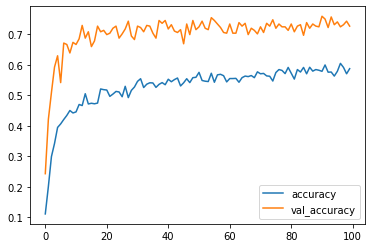

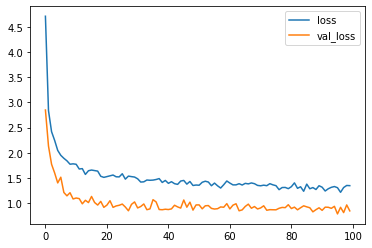

In [ ]:
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

## **Model 2**: Build a model from scratch

In [ ]:
model2 = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                                     tf.keras.layers.MaxPool2D(2,2),
                                     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                                     tf.keras.layers.MaxPool2D(2,2),
                                     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                     tf.keras.layers.MaxPool2D(2,2),
                                     tf.keras.layers.Dropout(0.5),
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dense(512, activation='relu'),
                                     tf.keras.layers.Dropout(0.5),
                                     tf.keras.layers.Dense(36, activation='softmax')])

model2.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

model2.fit(training_generator,
          validation_data=testing_generator,
          epochs=100,
          verbose=1)

Epoch 1/100
108/108 [==============================] - 36s 333ms/step - loss: 3.5757 - accuracy: 0.0353 - val_loss: 3.5375 - val_accuracy: 0.0648
Epoch 2/100
108/108 [==============================] - 36s 337ms/step - loss: 3.4818 - accuracy: 0.0660 - val_loss: 3.4081 - val_accuracy: 0.0602
Epoch 3/100
108/108 [==============================] - 35s 329ms/step - loss: 3.3126 - accuracy: 0.1053 - val_loss: 3.1562 - val_accuracy: 0.1366
Epoch 4/100
108/108 [==============================] - 36s 334ms/step - loss: 3.2022 - accuracy: 0.1128 - val_loss: 3.0806 - val_accuracy: 0.1852
Epoch 5/100
108/108 [==============================] - 36s 336ms/step - loss: 3.0877 - accuracy: 0.1331 - val_loss: 2.8697 - val_accuracy: 0.2083
Epoch 6/100
108/108 [==============================] - 36s 332ms/step - loss: 2.9852 - accuracy: 0.1684 - val_loss: 2.7969 - val_accuracy: 0.2361
Epoch 7/100
108/108 [==============================] - 36s 331ms/step - loss: 2.8787 - accuracy: 0.1950 - val_loss: 2.7754 -

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, None, None, 32)    896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, None, None, 32)   0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 32)    9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, None, None, 32)   0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 64)    18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, None, None, 64)  

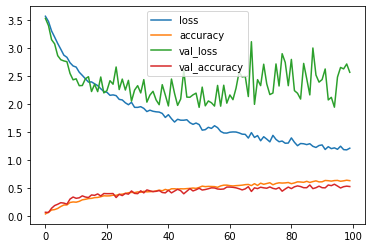

In [ ]:
metrics2 = pd.DataFrame(model2.history.history)
metrics2.plot()

## **Model 3**: Using pre trained model InceptionV3

In [ ]:
pre_trained_model3 = InceptionV3(include_top=False,
                                input_shape=(150,150,3),
                                weights='imagenet')

for layer in pre_trained_model3.layers:
  layer.trainable = False

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
pre_trained_model3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 74, 74, 32)   864         ['input_12[0][0]']               
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 74, 74, 32)  96          ['conv2d_12[0][0]']              
 rmalization)                                                                                     
                                                                                       

In [ ]:
last_layer = pre_trained_model3.get_layer('mixed7')
last_output = last_layer.output

In [ ]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(36, activation='softmax')(x)

model3 = tf.keras.Model(pre_trained_model3.input, x)

model3.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 74, 74, 32)   864         ['input_12[0][0]']               
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 74, 74, 32)  96          ['conv2d_12[0][0]']              
 rmalization)                                                                                     
                                                                                           

In [ ]:
model3.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

model3.fit(training_generator,
          validation_data=testing_generator,
          epochs=100,
          verbose=1)

Epoch 1/100
108/108 [==============================] - 42s 358ms/step - loss: 2.8790 - accuracy: 0.3096 - val_loss: 1.1854 - val_accuracy: 0.6319
Epoch 2/100
108/108 [==============================] - 38s 355ms/step - loss: 1.5137 - accuracy: 0.5799 - val_loss: 0.8102 - val_accuracy: 0.7569
Epoch 3/100
108/108 [==============================] - 37s 342ms/step - loss: 1.2111 - accuracy: 0.6406 - val_loss: 0.7502 - val_accuracy: 0.7639
Epoch 4/100
108/108 [==============================] - 37s 343ms/step - loss: 0.9775 - accuracy: 0.7147 - val_loss: 0.5639 - val_accuracy: 0.8171
Epoch 5/100
108/108 [==============================] - 37s 343ms/step - loss: 0.9035 - accuracy: 0.7315 - val_loss: 0.5472 - val_accuracy: 0.8218
Epoch 6/100
108/108 [==============================] - 37s 347ms/step - loss: 0.8356 - accuracy: 0.7390 - val_loss: 0.5238 - val_accuracy: 0.8356
Epoch 7/100
108/108 [==============================] - 38s 350ms/step - loss: 0.7157 - accuracy: 0.7737 - val_loss: 0.5328 -

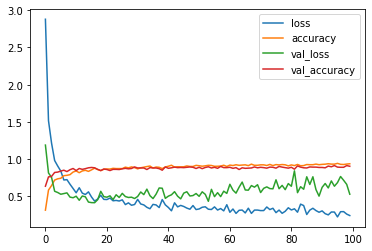

In [ ]:
metrics3 = pd.DataFrame(model3.history.history)
metrics3.plot()

## **Best Model**: Using pre trained model MobileNetV2
This is the improved model from the previous one, we got around 90% for accuracy

In [ ]:
pre_trained_model4 = MobileNetV2(include_top=False,
                                      input_shape=(150,150,3),
                                      weights='imagenet')

for layer in pre_trained_model4.layers:
  layer.trainable = False

In [ ]:
pre_trained_model4.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][

In [ ]:
last_layer = pre_trained_model4.get_layer('block_15_add')
last_output = last_layer.output

In [ ]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(36, activation='softmax')(x)

best_model = tf.keras.Model(pre_trained_model4.input, x)

best_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']         

In [ ]:
best_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

best_model.fit(training_generator,
          validation_data=testing_generator,
          epochs=100,
          verbose=1)

Epoch 1/100
108/108 [==============================] - 407s 4s/step - loss: 4.0784 - accuracy: 0.0544 - val_loss: 2.9825 - val_accuracy: 0.2431
Epoch 2/100
108/108 [==============================] - 36s 328ms/step - loss: 3.5572 - accuracy: 0.1042 - val_loss: 2.3614 - val_accuracy: 0.4514
Epoch 3/100
108/108 [==============================] - 35s 325ms/step - loss: 3.1544 - accuracy: 0.1759 - val_loss: 1.9565 - val_accuracy: 0.5764
Epoch 4/100
108/108 [==============================] - 36s 329ms/step - loss: 2.8265 - accuracy: 0.2587 - val_loss: 1.6645 - val_accuracy: 0.6481
Epoch 5/100
108/108 [==============================] - 35s 327ms/step - loss: 2.6278 - accuracy: 0.3032 - val_loss: 1.4624 - val_accuracy: 0.6875
Epoch 6/100
108/108 [==============================] - 35s 327ms/step - loss: 2.3987 - accuracy: 0.3351 - val_loss: 1.2885 - val_accuracy: 0.7245
Epoch 7/100
108/108 [==============================] - 36s 334ms/step - loss: 2.2772 - accuracy: 0.3808 - val_loss: 1.1664 - v

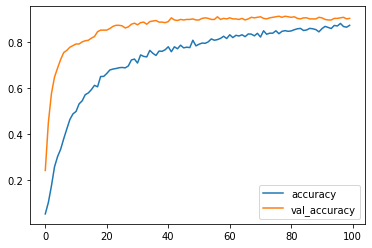

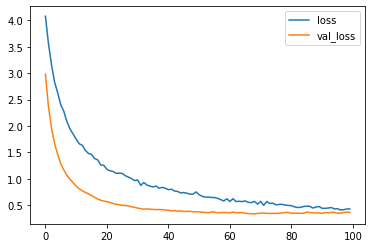

In [ ]:
metrics4 = pd.DataFrame(best_model.history.history)

metrics4[['accuracy', 'val_accuracy']].plot()
metrics4[['loss', 'val_loss']].plot()

In [ ]:
#save model using keras
best_model.save('mobilenet_final.h5')

#save model using tensorflow saved_model
#tf.saved_model.save(best_model, 'mobilenet_final/1')

INFO:tensorflow:Assets written to: mobilenet_final/1/assets


## **Test The Model Performance with Images Taken by Smartphone**

In [ ]:
class_name = training_generator.class_indices
inv_class_name = {v: k for k, v in class_name.items()}

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Capstone Project/Model/mobilenet_final.h5')

Saving 739949.jpg to 739949 (4).jpg
Saving 739946.jpg to 739946 (1).jpg
Saving 739942.jpg to 739942 (1).jpg
Saving 739939.jpg to 739939 (1).jpg
Saving 739852.jpg to 739852 (2).jpg


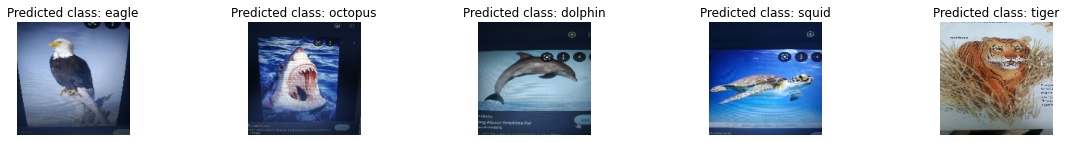

In [ ]:
from google.colab import files
from keras.preprocessing import image

fig = plt.figure(figsize=(20,12))
uploaded=files.upload()

i = 0
for fn in uploaded.keys():
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = loaded_model.predict(images, batch_size=10)
  classes = np.argmax(classes, axis=1)

  ax = fig.add_subplot(len(uploaded.keys()), len(uploaded.keys()), i + 1)
  i+=1
  
  ax.axis('Off') # Don't show axes (or gridlines)
  plt.imshow(img)
  plt.title('Predicted class: '+inv_class_name[classes[0]])

The result was not quite good since our training and test data consist of images with higher resolution and good lighting, whereas the above images are taken in different situation. As you can see, most of images are blurry with dark background

## Convert Tensorflow Model to Tensorflow Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/Capstone Project/Model/mobilenet_final/1')

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
#save the model
with open('best_model.tflite', 'wb') as f:
  f.write(tflite_model)